### VNL 2025 Predictor

##### This project aims to predict the Women's VNL (Volleyball Nations Leauge) 2025 winner with the data obtained from the official website like World Rankings, VNL 2025 tournament statistics until the finals round, individual players' rankings and statistics. 

In [4]:
import pandas as pd

def parse_world_rankings(file_path):
    """
    Parses the world-rankings.txt file and returns a DataFrame with [Rank,Country,Points] columns.
    Args:
        file_path (str): Path to the world-rankings.txt file.
    Returns:
        pd.DataFrame: DataFrame containing the rankings with columns [Rank, Country, Points].
    """
    data = []

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().split('❮')  # each individual entry in the .txt is separated by '❮'

    for block in lines:
        block = block.strip()
        if not block:
            continue 

        parts = block.split('\n')
        if len(parts) < 4:
            continue 

        try:
            rank = int(parts[0].strip())
            country = parts[2].strip()
            points = float(parts[3].strip())
            data.append({'Rank': rank, 'Country': country, 'Points': points}) 
        except Exception as e:
            print(f"Skipping block due to error: {e}")
            continue

    df = pd.DataFrame(data)
    return df

world_df = parse_world_rankings("world-rankings.txt")
print(world_df)
print(world_df.shape)

    Rank                 Country  Points
0      1                   Italy  460.37
1      2                  Brazil  429.18
2      3                  Poland  357.72
3      4                   Japan  352.16
4      5                   China  348.79
5      6                 Türkiye  342.02
6      7                     USA  341.10
7      8             Netherlands  262.75
8      9                  Serbia  261.84
9     10                 Germany  254.15
10    11      Dominican Republic  248.35
11    12                  Canada  237.78
12    13                 Czechia  205.94
13    14                  France  192.72
14    15                 Ukraine  192.10
15    16               Argentina  189.05
16    17                 Belgium  188.78
17    18             Puerto Rico  182.58
18    19                Bulgaria  163.03
19    20                Thailand  161.27
20    21                Colombia  152.37
21    22                   Kenya  152.15
22    23                  Sweden  149.09
23    24        

In [2]:
from bs4 import BeautifulSoup

def parse_vnl_teams(html_file):
    """
    Parses VNL 2025 teams from the HTML file and returns a dictionary:
    { 'Country': 'Code', ... }
    Args:        
    html_file (str): Path to the HTML file containing VNL 2025 teams.
    Returns:
        dict: Dictionary with country names as keys and their codes as values.
    """
    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'html.parser')

    teams = {}

    # Find all parent <a> blocks (each team)
    for a_tag in soup.find_all('a', class_='d3-l-col__col-2'):
        name_div = a_tag.find('div', class_='vbw-mu__team__name')
        code_div = a_tag.find('div', class_='vbw-mu__team__name vbw-mu__team__name--abbr')

        if name_div and code_div:
            name = name_div.text.strip()
            code = code_div.text.strip()
            teams[name] = code

    return teams

# Example usage:
teams_dict = parse_vnl_teams('vnl-2025-teams.html')
print(teams_dict)

{'Belgium': 'BEL', 'Brazil': 'BRA', 'Bulgaria': 'BUL', 'Canada': 'CAN', 'China': 'CHN', 'Czechia': 'CZE', 'Dominican Republic': 'DOM', 'France': 'FRA', 'Germany': 'GER', 'Italy': 'ITA', 'Japan': 'JPN', 'Korea': 'KOR', 'Netherlands': 'NED', 'Poland': 'POL', 'Serbia': 'SRB', 'Thailand': 'THA', 'Türkiye': 'TUR', 'USA': 'USA'}


In [5]:
def filter_and_add_code(world_df, teams_dict):
    """
    Filter world_df to keep only rows where Country is in teams_dict keys.
    Add 'Code' column from teams_dict.
    """
    # Filter
    filtered_df = world_df[world_df['Country'].isin(teams_dict.keys())].copy()

    # Map code
    filtered_df['Code'] = filtered_df['Country'].map(teams_dict)

    return filtered_df

# Example usage:
filtered_df = filter_and_add_code(world_df, teams_dict)
print(filtered_df)
print(filtered_df.shape)

    Rank             Country  Points Code
0      1               Italy  460.37  ITA
1      2              Brazil  429.18  BRA
2      3              Poland  357.72  POL
3      4               Japan  352.16  JPN
4      5               China  348.79  CHN
5      6             Türkiye  342.02  TUR
6      7                 USA  341.10  USA
7      8         Netherlands  262.75  NED
8      9              Serbia  261.84  SRB
9     10             Germany  254.15  GER
10    11  Dominican Republic  248.35  DOM
11    12              Canada  237.78  CAN
12    13             Czechia  205.94  CZE
13    14              France  192.72  FRA
16    17             Belgium  188.78  BEL
18    19            Bulgaria  163.03  BUL
19    20            Thailand  161.27  THA
36    37               Korea   99.53  KOR
(18, 4)


In [7]:
def parse_more_details(file_path, teams_dict):
    """
    Parse the detailed matches file into a clean DataFrame:
    - One row per match
    - Only VNL 2025 teams
    - Columns: Date, Team_A, Team_A_Points, Team_B, Team_B_Points, Result, Points_Change, Team_A_Won
    """
    matches = []

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    current_date = None

    for line in lines:
        line = line.strip()

        # Is it a date line?
        if line and not '\t' in line and not line.startswith('+/-'):
            current_date = line
            continue

        # Skip headers and empty lines
        if not line or line.startswith('Date') or line.startswith('+/'):
            continue

        # It’s a match row
        parts = line.split('\t')
        if len(parts) < 7:
            continue  # Skip malformed

        team_a = parts[0].strip()
        team_a_points = float(parts[1].strip())
        team_b_points = float(parts[2].strip())
        team_b = parts[3].strip()
        result = parts[5].strip()
        points_change = parts[6].strip().replace('+', '')  # remove plus sign
        points_change = float(points_change)

        # Only keep matches where both teams are VNL teams
        if team_a not in teams_dict.values() or team_b not in teams_dict.values():
            continue

        # Determine winner
        sets = result.split('-')
        team_a_sets = int(sets[0].strip())
        team_b_sets = int(sets[1].strip())

        team_a_won = 1 if team_a_sets > team_b_sets else 0

        matches.append({
            'Date': current_date,
            'Team_A': team_a,
            'Team_A_Points': team_a_points,
            'Team_B': team_b,
            'Team_B_Points': team_b_points,
            'Result': result,
            'Points_Change': points_change,
            'Team_A_Won': team_a_won
        })

    df = pd.DataFrame(matches)
    return df

# Example usage:
matches_df = parse_more_details('more-details.txt', teams_dict)
print(matches_df.head())
print(matches_df.shape)

           Date Team_A  Team_A_Points Team_B  Team_B_Points Result  \
0  Jul 13, 2025    NED         264.41    ITA         458.71  0 - 3   
1  Jul 12, 2025    TUR         357.78    ITA         458.70  2 - 3   
2  Jul 10, 2025    ITA         457.49    SRB         240.25  3 - 0   
3   Jul 9, 2025    ITA         456.91    BEL         190.65  3 - 0   
4  Jun 22, 2025    CHN         351.47    ITA         452.19  0 - 3   

   Points_Change  Team_A_Won  
0           1.66           0  
1           0.01           0  
2           1.22           1  
3           0.58           1  
4           4.72           0  
(727, 8)


In [11]:
def aggregate_player_stats(player_df):
    team_stats = (
        player_df
        .groupby('Team')
        .apply(lambda df: pd.Series({
            'Top_Scorer_Points': df['Points'].max(),
            'Top_3_Avg_Points': df.nlargest(3, 'Points')['Points'].mean(),
            'Team_Avg_Success_%': df['Success %'].mean(),
            'Team_Avg_Errors': df['Errors'].mean(),
            'Num_Players_150+': (df['Points'] > 150).sum()
        }))
        .reset_index()
    )
    # Easy offense score
    team_stats['Offense_Score'] = team_stats['Top_3_Avg_Points'] * (team_stats['Team_Avg_Success_%'] / 100)
    return team_stats

# Example usage:
player_stats_df = pd.read_csv('individuals-vnl-2025.tsv',delimiter='\t')  # Assuming player stats are in this CS
print(player_stats_df.head())

team_stats_df = aggregate_player_stats(player_stats_df)
print(team_stats_df)

   Rank  Player Name Team  Points  Errors  Attempts  Average per match  \
0     1       Ndiaye  FRA     190      75       179              15.83   
1     2  B. Martinez  DOM     181      40       200              15.08   
2     3      Wu M.J.  CHN     178      47       177              17.80   
3     4     Alsmeier  GER     170      57       162              14.17   
4     5         Wada  JPN     166      47       146              13.83   

   Success %  Total  
0      42.79    444  
1      42.99    421  
2      44.28    402  
3      43.70    389  
4      46.24    359  
   Team  Top_Scorer_Points  Top_3_Avg_Points  Team_Avg_Success_%  \
0   BEL              135.0        107.000000           39.733333   
1   BRA              147.0        113.666667           43.988571   
2   BUL              129.0        103.000000           32.005333   
3   CAN               98.0         88.000000           47.900714   
4   CHN              178.0        145.666667           44.717500   
5   CZE        

/var/folders/38/kvr29r_s0_3bpzlvqgh6zksr0000gn/T/ipykernel_94229/4214128814.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


In [12]:
def merge_features(matches_df, world_df, team_stats_df):
    """
    Add pre-match rank, points, offense score for both teams.
    """
    # Keep only needed columns
    world_cols = ['Code', 'Rank', 'Points']
    team_stats_cols = ['Team', 'Offense_Score']
    
    # Merge for Team A
    df = matches_df.merge(world_df[world_cols], left_on='Team_A', right_on='Code', how='left')
    df = df.merge(team_stats_df[team_stats_cols], left_on='Team_A', right_on='Team', how='left')
    df = df.rename(columns={
        'Rank': 'Team_A_Rank',
        'Points': 'Team_A_WorldPoints',
        'Offense_Score': 'Team_A_Offense'
    }).drop(columns=['Code', 'Team'])

    # Merge for Team B
    df = df.merge(world_df[world_cols], left_on='Team_B', right_on='Code', how='left')
    df = df.merge(team_stats_df[team_stats_cols], left_on='Team_B', right_on='Team', how='left')
    df = df.rename(columns={
        'Rank': 'Team_B_Rank',
        'Points': 'Team_B_WorldPoints',
        'Offense_Score': 'Team_B_Offense'
    }).drop(columns=['Code', 'Team'])

    return df

In [13]:
def create_features(df):
    df['Rank_Diff'] = df['Team_A_Rank'] - df['Team_B_Rank']
    df['Points_Diff'] = df['Team_A_WorldPoints'] - df['Team_B_WorldPoints']
    df['Offense_Diff'] = df['Team_A_Offense'] - df['Team_B_Offense']
    return df

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def baseline_model(df):
    features = ['Rank_Diff', 'Points_Diff', 'Offense_Diff']
    X = df[features]
    y = df['Team_A_Won']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f'Baseline Accuracy: {acc:.3f}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    return model

In [16]:
# 1. Merge features
merged_df = merge_features(matches_df, filtered_df, team_stats_df)

# 2. Create differences
features_df = create_features(merged_df)

# 3. Train baseline
model = baseline_model(features_df)

Baseline Accuracy: 0.740
Confusion Matrix:
[[62 11]
 [27 46]]


In [19]:
import pandas as pd

def prepare_match_input(team_a, team_b, filtered_df, team_stats_df):
    # Get A info
    a_info = filtered_df.merge(team_stats_df, left_on='Code', right_on='Team')
    a_row = a_info[a_info['Code'] == team_a]
    b_row = a_info[a_info['Code'] == team_b]

    Rank_Diff = a_row['Rank'].values[0] - b_row['Rank'].values[0]
    Points_Diff = a_row['Points'].values[0] - b_row['Points'].values[0]
    Offense_Diff = a_row['Offense_Score'].values[0] - b_row['Offense_Score'].values[0]

    return {
        'Rank_Diff': Rank_Diff,
        'Points_Diff': Points_Diff,
        'Offense_Diff': Offense_Diff
    }

# Example upcoming matches — use CODE not country name!
upcoming = [
    ('ITA', 'USA'),  # Italy vs USA
    ('POL', 'CHN'),  # Poland vs China
    ('JPN', 'TUR'),  # Japan vs Türkiye
    ('BRA', 'GER')   # Brazil vs Germany
]

# Prepare all
X_new = []
match_names = []
for a, b in upcoming:
    features = prepare_match_input(a, b, filtered_df, team_stats_df)
    X_new.append(features)
    match_names.append(f"{a} vs {b}")

X_new_df = pd.DataFrame(X_new)

# Predict win probability for Team A
probabilities = model.predict_proba(X_new_df)[:, 1]

# Show results
for match, prob in zip(match_names, probabilities):
    print(f"{match}: Team A win probability = {prob:.2%}")

ITA vs USA: Team A win probability = 80.19%
POL vs CHN: Team A win probability = 55.80%
JPN vs TUR: Team A win probability = 42.07%
BRA vs GER: Team A win probability = 89.83%


In [25]:
pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def run_models(df):
    X = df[['Rank_Diff', 'Points_Diff', 'Offense_Diff']]
    y = df['Team_A_Won']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "Neural Net": MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=1000, random_state=42)
    }

    trained_models = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Confusion Matrix": cm
        })
        trained_models[name] = model

    return results, trained_models

# Run
results, trained_models = run_models(features_df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/var/folders/38/kvr29r_s0_3bpzlvqgh6zksr0000gn/T/ipykernel_94229/739670632.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")


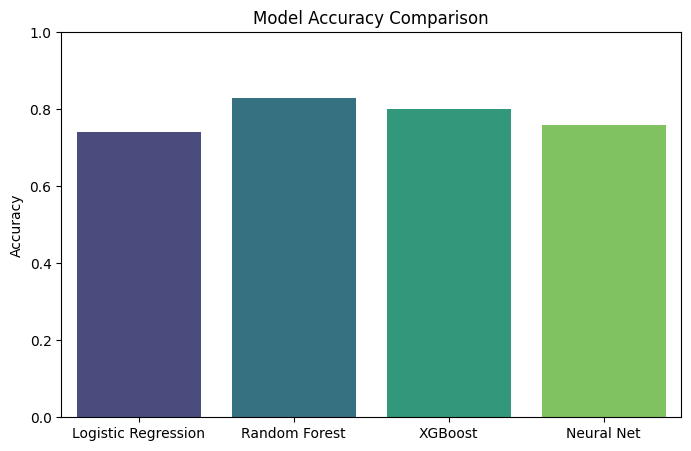

In [28]:
# Plot accuracy comparison
model_names = [r["Model"] for r in results]
accuracies = [r["Accuracy"] for r in results]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.show()

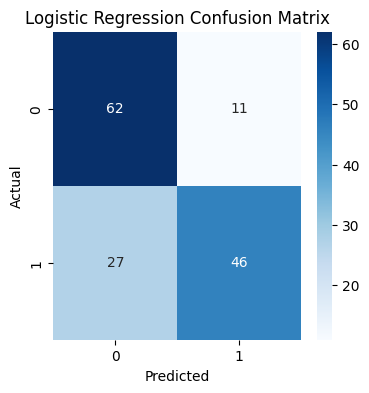

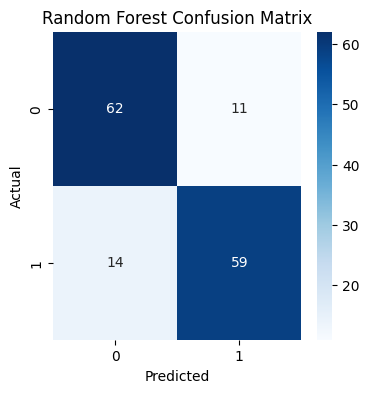

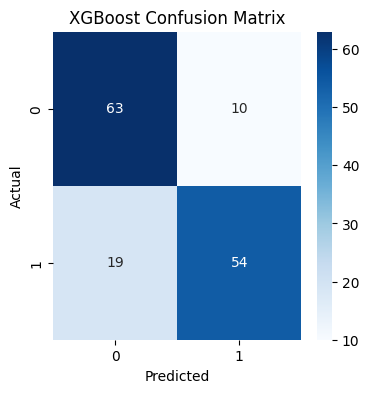

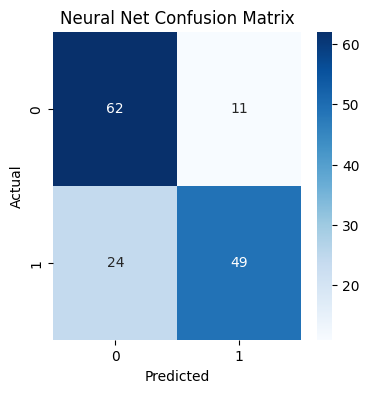

In [29]:
# Plot confusion matrices
for r in results:
    cm = r["Confusion Matrix"]
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{r['Model']} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [31]:
# Prepare upcoming matches
X_new_df = pd.DataFrame([prepare_match_input(a, b, filtered_df, team_stats_df) 
                         for a, b in upcoming])
match_names = [f"{a} vs {b}" for a, b in upcoming]

# Predict for each model
for name, model in trained_models.items():
    probs = model.predict_proba(X_new_df)[:, 1]
    print(f"\n{name} predictions:")
    for match, prob in zip(match_names, probs):
        print(f"{match}: Team A win probability = {prob:.2%}")


Logistic Regression predictions:
ITA vs USA: Team A win probability = 80.19%
POL vs CHN: Team A win probability = 55.80%
JPN vs TUR: Team A win probability = 42.07%
BRA vs GER: Team A win probability = 89.83%

Random Forest predictions:
ITA vs USA: Team A win probability = 81.43%
POL vs CHN: Team A win probability = 20.83%
JPN vs TUR: Team A win probability = 64.68%
BRA vs GER: Team A win probability = 96.54%

XGBoost predictions:
ITA vs USA: Team A win probability = 81.21%
POL vs CHN: Team A win probability = 11.67%
JPN vs TUR: Team A win probability = 61.69%
BRA vs GER: Team A win probability = 98.67%

Neural Net predictions:
ITA vs USA: Team A win probability = 81.46%
POL vs CHN: Team A win probability = 35.23%
JPN vs TUR: Team A win probability = 52.14%
BRA vs GER: Team A win probability = 94.75%


In [32]:
filtered_df.to_csv('world_df.csv', index=False)
team_stats_df.to_csv('team_stats.csv', index=False)

trained_models['XGBoost'].save_model('xgboost_model.json')

import joblib

# Save sklearn models:
joblib.dump(trained_models['Logistic Regression'], 'logistic_model.pkl')
joblib.dump(trained_models['Random Forest'], 'random_forest_model.pkl')
joblib.dump(trained_models['Neural Net'], 'neural_net_model.pkl')


['neural_net_model.pkl']